# FROM 4OYD


## Question: Can we fold 3LHP and expect it to mimic the configuration of 4OYD?

In this scenario, we use __3LHP__ as template, and __4OYD__ as the source of our motif and binder and as the final target conformation we are aiming to mimic.

We will run the protocol with and without a binder. Using full CA constraints from the template (_fullcst_) or just constraints between residues belonging to the same secondary structure (_ssecst_).

We will first have a *no_design* run that entails only the __NubInitioMover__. This runs will generate poses that have to be considered as non-final, and, thus, should not be considered on their own without further processing.

After that, different design rules are tested:  

* __minimizeBinderAlternate:__ For 3 rounds, we will alternate __FastDesign__ with the classical _FFL rules_ with minimization of the _binder_. 


### Nomenclature:

* __Template:__ Structure that will accomodate the query motif.  
* __Design:__ Chain that we are designing; contains the query motif and is guided by the template info.  
* __Binder:__ If any, is whatever protein(s) bind to the query motif.  
* __Target:__ Protein that we expect our design to resemble to and to which we compare.  

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy

sns.set(font_scale=1.5)

In [4]:
experiments = "minimizeBinderAlternate/output/design_minimizeBinderAlternate_1_minisilent"
definition = {
    "scores":{
        "description": "description", "design_score": "score",
        "GRMSD2Target": "GRMSD2Target",
        "LRMSD2Target": "LRMSD2Target", "LRMSDH2Target": "LRMSDH2Target", "LRMSDLH2Target": "LRMSDLH2Target"
    },
    "naming": ["", "", "", "", "cluster", "decoy", "experiment", "", "", ""]
}

In [7]:
dlist         = rstoolbox.api.read_rosetta_silent(experiments)
minb_alt_data = rstoolbox.api.process_from_definitions(dlist, definition)

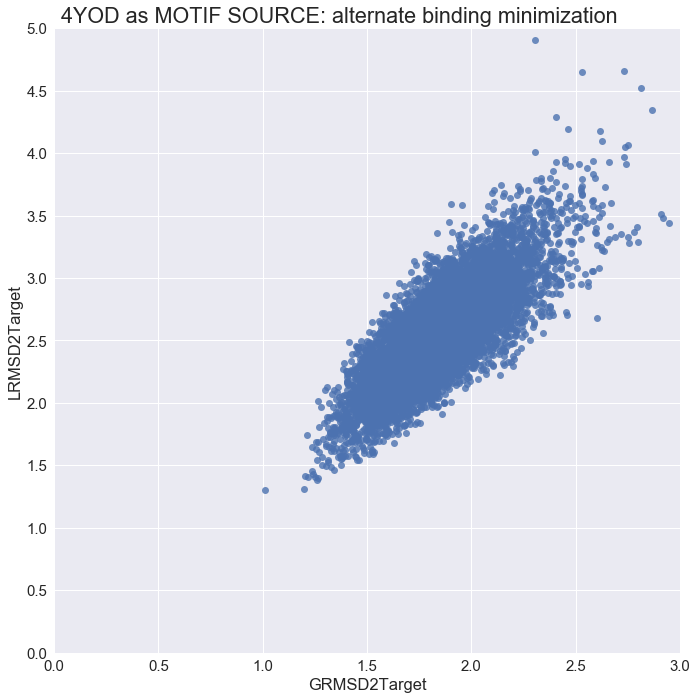

In [21]:
g = sns.lmplot(x="GRMSD2Target", y="LRMSD2Target", data=minb_alt_data, fit_reg=False, size=10)
plt.subplots_adjust(top=0.95)
g.axes[0,0].set_ylim(0,5)
g.axes[0,0].set_xlim(0,3)
g.axes[0,0].set_yticks(np.arange(0,5.5,0.5))
g.fig.suptitle('4YOD as MOTIF SOURCE: alternate binding minimization')
sns.plt.show()